In [ ]:

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random
import pickle
from pathlib import Path
import cv2
import os


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive"

In [ ]:
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset


In [ ]:
# !unzip plantvillage-dataset.zip

In [ ]:
!cp /content/gdrive/MyDrive/plantvillage_dataset/color/Apple___Apple_scab /content/gdrive/MyDrive/test_scab_vs_health_apples

cp: -r not specified; omitting directory '/content/gdrive/MyDrive/plantvillage_dataset/color/Apple___Apple_scab'


In [ ]:

root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'plantvillage_dataset/color/' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"

In [ ]:
classes = ['Apple___Apple_scab','Apple___healthy']
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

Apple___Apple_scab
Apple___healthy


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

In [ ]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

# Feed preprocessed image through CNN encoder to get a new feature representation
mobilenet_features = conv_base.predict(img_preprocessed)

File path: /content/gdrive/My Drive/plantvillage_dataset/color/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112.JPG


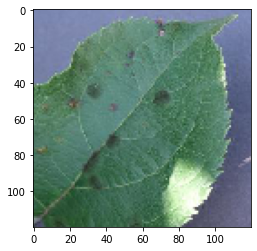

In [ ]:
plt.imshow(img)

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
gen_path = p
train_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
N = 2
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

In [ ]:
from tensorflow.keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

In [ ]:
from google.colab import files
files.download('/content/gdrive/MyDrive/plantvillage_dataset/color/Apple___Apple_scab')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>